# Analisando o desempenho da localização pulmonar em problemas de classificação de distúrbios pulmonares
***

### Instalação e Importação dos Pacotes
***

In [ ]:
!pip install lungs_segmentation

In [51]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, average_precision_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, multilabel_confusion_matrix
from sklearn.model_selection import train_test_split
from bbox_delimiters import bbox_utils
import matplotlib.pyplot as plt
from google.colab import drive 
import urllib.request as url
import seaborn as sn
import pandas as pd
import numpy as np
import random
import time
import cv2

from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet_v2 import ResNet101V2
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.vgg19 import VGG19
import tensorflow as tf

### Baixando as Imagens do Conjunto de Dados CheXpert
***

In [ ]:
drive.mount('/content/gdrive', force_remount = True)
!cp -r /content/gdrive/MyDrive/datasets/chexpert-v10-small.zip /content/
!unzip /content/chexpert-v10-small.zip
!rm /content/chexpert-v10-small.zip

### Pré-processamento nos Dados
***

In [2]:
image_size, batch_size = 256, 32
df = pd.read_csv('/content/CheXpert-v1.0-small/train.csv', delimiter = ',')

labels = ['Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Atelectasis', 
          'Pneumothorax', 'Pleural Effusion']

In [3]:
df = df[df['Frontal/Lateral'] == 'Frontal'].copy()
df.drop(labels = 'Frontal/Lateral', axis = 1, inplace = True)

df.drop(labels = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
                  'Fracture', 'Support Devices'], axis = 1, inplace = True)

df = df[(df['AP/PA'] == 'AP') | (df['AP/PA'] == 'PA')].copy()
df.drop(labels = 'AP/PA', axis = 1, inplace = True)
 
df = df[(df['Age'] <= 80) | (df['Age'] >= 10)]
df.drop(labels = 'Age', axis = 1, inplace = True)

df.drop(labels=['Sex', 'Pneumonia', 'Pleural Other'], axis=1, inplace=True)

df.replace(to_replace = float('NaN'), value = 0.0, inplace = True)
df.replace(to_replace = -1.0, value = 0.0, inplace = True)

In [4]:
def count_values(dataframe, label):
  '''
  conta o número de casos positivos de uma classe no conjunto de dados

  Args:
    dataframe (pandas) --> dataframe do conjunto de dados
    label (str) --> nome da classe em análise 

  Returns:
    lenght_dataframe (int) --> número de casos positivos na classe em análise

  '''

  return len(dataframe[dataframe[label] == 1.0])

In [5]:
print('{}: {} Imagens'.format(labels[0], count_values(df, labels[0])))
print('{}: {} Imagens'.format(labels[1], count_values(df, labels[1])))
print('{}: {} Imagens'.format(labels[2], count_values(df, labels[2])))
print('{}: {} Imagens'.format(labels[3], count_values(df, labels[3])))
print('{}: {} Imagens'.format(labels[4], count_values(df, labels[4])))
print('{}: {} Imagens'.format(labels[5], count_values(df, labels[5])))
print('{}: {} Imagens'.format(labels[6], count_values(df, labels[6])))

Lung Opacity: 94207 Imagens
Lung Lesion: 7040 Imagens
Edema: 49674 Imagens
Consolidation: 12982 Imagens
Atelectasis: 29718 Imagens
Pneumothorax: 17693 Imagens
Pleural Effusion: 76894 Imagens


In [6]:
lung_opacity = df[(df[labels[0]] == 1.) & (df[labels[1]] != 1.) & (df[labels[2]] != 1.) & (df[labels[3]] != 1.) &
                  (df[labels[4]] != 1.) & (df[labels[5]] != 1.) & (df[labels[6]] != 1.)].index

lung_lesion = df[(df[labels[0]] != 1.) & (df[labels[1]] == 1.) & (df[labels[2]] != 1.) & (df[labels[3]] != 1.) &
                 (df[labels[4]] != 1.) & (df[labels[5]] != 1.) & (df[labels[6]] != 1.)].index

edema = df[(df[labels[0]] != 1.) & (df[labels[1]] != 1.) & (df[labels[2]] == 1.) & (df[labels[3]] != 1.) &
           (df[labels[4]] != 1.) & (df[labels[5]] != 1.) &  (df[labels[6]] != 1.)].index

consolidation = df[(df[labels[0]] != 1.) & (df[labels[1]] != 1.) & (df[labels[2]] != 1.) & (df[labels[3]] == 1.) &
                   (df[labels[4]] != 1.) & (df[labels[5]] != 1.) & (df[labels[6]] != 1.)].index

atelectasis = df[(df[labels[0]] != 1.) & (df[labels[1]] != 1.) & (df[labels[2]] != 1.) & (df[labels[3]] != 1.) &
                 (df[labels[4]] == 1.) & (df[labels[5]] != 1.) & (df[labels[6]] != 1.)].index

pneumothorax = df[(df[labels[0]] != 1.) & (df[labels[1]] != 1.) & (df[labels[2]] != 1.) & (df[labels[3]] != 1.) &
                  (df[labels[4]] != 1.) & (df[labels[5]] == 1.) & (df[labels[6]] != 1.)].index
  
pleural_effusion = df[(df[labels[0]] != 1.) & (df[labels[1]] != 1.) & (df[labels[2]] != 1.) & (df[labels[3]] != 1.) &
                      (df[labels[4]] != 1.) & (df[labels[5]] != 1.) & (df[labels[6]] == 1.)].index

In [7]:
print('Imagens com rótulos individuais:\n')
print('{}: {} Imagens'.format(labels[0], len(lung_opacity)))
print('{}: {} Imagens'.format(labels[1], len(lung_lesion)))
print('{}: {} Imagens'.format(labels[2], len(edema)))
print('{}: {} Imagens'.format(labels[3], len(consolidation)))
print('{}: {} Imagens'.format(labels[4], len(atelectasis)))
print('{}: {} Imagens'.format(labels[5], len(pneumothorax)))
print('{}: {} Imagens'.format(labels[6], len(pleural_effusion)))

Imagens com rótulos individuais:

Lung Opacity: 23005 Imagens
Lung Lesion: 1385 Imagens
Edema: 9728 Imagens
Consolidation: 2570 Imagens
Atelectasis: 5088 Imagens
Pneumothorax: 5177 Imagens
Pleural Effusion: 9214 Imagens


In [8]:
df_pure_multilabel = pd.concat((df.drop(lung_opacity), df.drop(lung_lesion), df.drop(edema), df.drop(consolidation),
                                df.drop(atelectasis), df.drop(pneumothorax), df.drop(pleural_effusion)))

In [9]:
print('Imagens que compartilham mais de um rótulo:\n')
print('{}: {} Imagens'.format(labels[0], count_values(df_pure_multilabel, labels[0])))
print('{}: {} Imagens'.format(labels[1], count_values(df_pure_multilabel, labels[1])))
print('{}: {} Imagens'.format(labels[2], count_values(df_pure_multilabel, labels[2])))
print('{}: {} Imagens'.format(labels[3], count_values(df_pure_multilabel, labels[3])))
print('{}: {} Imagens'.format(labels[4], count_values(df_pure_multilabel, labels[4])))
print('{}: {} Imagens'.format(labels[5], count_values(df_pure_multilabel, labels[5])))
print('{}: {} Imagens'.format(labels[6], count_values(df_pure_multilabel, labels[6])))

Imagens que compartilham mais de um rótulo:

Lung Opacity: 636444 Imagens
Lung Lesion: 47895 Imagens
Edema: 337990 Imagens
Consolidation: 88304 Imagens
Atelectasis: 202938 Imagens
Pneumothorax: 118674 Imagens
Pleural Effusion: 529044 Imagens


In [10]:
ts1 = df_pure_multilabel.sample(n = 7040, weights = labels[1], random_state = 42)
ts2 = df_pure_multilabel.drop(ts1.index).sample(n = 7040, weights = labels[3], random_state = 42)
ts3 = df_pure_multilabel.drop(pd.concat([ts1, ts2]).index).sample(n = 7040, weights = labels[5], random_state = 42)
ts4 = df_pure_multilabel.drop(pd.concat([ts1, ts2, ts3]).index).sample(n = 4000, weights = labels[2], random_state = 42)
ts5 = df_pure_multilabel.drop(pd.concat([ts1, ts2, ts3, ts4]).index).sample(n = 4000, weights = labels[4], random_state = 42)

df_more_balanced = pd.concat([ts1, ts2, ts3, ts4, ts5])

In [11]:
print('{}: {} Imagens'.format(labels[0], count_values(df_more_balanced, labels[0])))
print('{}: {} Imagens'.format(labels[1], count_values(df_more_balanced, labels[1])))
print('{}: {} Imagens'.format(labels[2], count_values(df_more_balanced, labels[2])))
print('{}: {} Imagens'.format(labels[3], count_values(df_more_balanced, labels[3])))
print('{}: {} Imagens'.format(labels[4], count_values(df_more_balanced, labels[4])))
print('{}: {} Imagens'.format(labels[5], count_values(df_more_balanced, labels[5])))
print('{}: {} Imagens'.format(labels[6], count_values(df_more_balanced, labels[6])))

Lung Opacity: 14445 Imagens
Lung Lesion: 7308 Imagens
Edema: 8223 Imagens
Consolidation: 8072 Imagens
Atelectasis: 7788 Imagens
Pneumothorax: 8566 Imagens
Pleural Effusion: 12939 Imagens


In [12]:
lung_opacity = df_more_balanced[(df_more_balanced[labels[0]] == 1.)]
lung_opacity = lung_opacity.sample(n = 8000, random_state = 42)
df_more_balanced.drop(lung_opacity.index, inplace = True)

In [13]:
print('{}: {} Imagens'.format(labels[0], count_values(df_more_balanced, labels[0])))
print('{}: {} Imagens'.format(labels[1], count_values(df_more_balanced, labels[1])))
print('{}: {} Imagens'.format(labels[2], count_values(df_more_balanced, labels[2])))
print('{}: {} Imagens'.format(labels[3], count_values(df_more_balanced, labels[3])))
print('{}: {} Imagens'.format(labels[4], count_values(df_more_balanced, labels[4])))
print('{}: {} Imagens'.format(labels[5], count_values(df_more_balanced, labels[5])))
print('{}: {} Imagens'.format(labels[6], count_values(df_more_balanced, labels[6])))

Lung Opacity: 5034 Imagens
Lung Lesion: 4133 Imagens
Edema: 5786 Imagens
Consolidation: 5954 Imagens
Atelectasis: 5645 Imagens
Pneumothorax: 5802 Imagens
Pleural Effusion: 8671 Imagens


In [14]:
pleural_effusion = df_more_balanced[(df_more_balanced[labels[6]] == 1.)]
pleural_effusion = pleural_effusion.sample(n = 2671, random_state = 42)
df_more_balanced.drop(pleural_effusion.index, inplace = True)

In [15]:
print('{}: {} Imagens'.format(labels[0], count_values(df_more_balanced, labels[0])))
print('{}: {} Imagens'.format(labels[1], count_values(df_more_balanced, labels[1])))
print('{}: {} Imagens'.format(labels[2], count_values(df_more_balanced, labels[2])))
print('{}: {} Imagens'.format(labels[3], count_values(df_more_balanced, labels[3])))
print('{}: {} Imagens'.format(labels[4], count_values(df_more_balanced, labels[4])))
print('{}: {} Imagens'.format(labels[5], count_values(df_more_balanced, labels[5])))
print('{}: {} Imagens'.format(labels[6], count_values(df_more_balanced, labels[6])))

Lung Opacity: 4145 Imagens
Lung Lesion: 3470 Imagens
Edema: 4646 Imagens
Consolidation: 4685 Imagens
Atelectasis: 4635 Imagens
Pneumothorax: 5146 Imagens
Pleural Effusion: 5405 Imagens


In [16]:
lung_opacity = df[(df[labels[0]] == 1.) & (df[labels[1]] != 1.) & (df[labels[2]] != 1.) & (df[labels[3]] != 1.) &
                  (df[labels[4]] != 1.) & (df[labels[5]] != 1.) & (df[labels[6]] != 1.)]

lung_lesion = df[(df[labels[0]] != 1.) & (df[labels[1]] == 1.) & (df[labels[2]] != 1.) & (df[labels[3]] != 1.) &
                 (df[labels[4]] != 1.) & (df[labels[5]] != 1.) & (df[labels[6]] != 1.)]

edema = df[(df[labels[0]] != 1.) & (df[labels[1]] != 1.) & (df[labels[2]] == 1.) & (df[labels[3]] != 1.) &
           (df[labels[4]] != 1.) & (df[labels[5]] != 1.) & (df[labels[6]] != 1.)]

consolidation = df[(df[labels[0]] != 1.) & (df[labels[1]] != 1.) & (df[labels[2]] != 1.) & (df[labels[3]] == 1.) &
                   (df[labels[4]] != 1.) & (df[labels[5]] != 1.) & (df[labels[6]] != 1.)]

atelectasis = df[(df[labels[0]] != 1.) & (df[labels[1]] != 1.) & (df[labels[2]] != 1.) & (df[labels[3]] != 1.) &
                 (df[labels[4]] == 1.) & (df[labels[5]] != 1.) & (df[labels[6]] != 1.)]

pneumothorax = df[(df[labels[0]] != 1.) & (df[labels[1]] != 1.) & (df[labels[2]] != 1.) & (df[labels[3]] != 1.) &
                  (df[labels[4]] != 1.) & (df[labels[5]] == 1.) & (df[labels[6]] != 1.)]
  
pleural_effusion = df[(df[labels[0]] != 1.) & (df[labels[1]] != 1.) & (df[labels[2]] != 1.) & (df[labels[3]] != 1.) &
                      (df[labels[4]] != 1.) & (df[labels[5]] != 1.) & (df[labels[6]] == 1.)]

In [17]:
final_df = pd.concat((df_more_balanced, lung_opacity.sample(n = 1855, random_state = 42), lung_lesion, 
                      edema.sample(n = 1354, random_state = 42), consolidation.sample(n = 1315, random_state = 42),
                      atelectasis.sample(n = 1364, random_state = 42), pneumothorax.sample(n = 854, random_state = 42),
                      pleural_effusion.sample(n = 594, random_state = 42)))   

In [18]:
print('{}: {} Imagens'.format(labels[0], count_values(final_df, labels[0])))
print('{}: {} Imagens'.format(labels[1], count_values(final_df, labels[1])))
print('{}: {} Imagens'.format(labels[2], count_values(final_df, labels[2])))
print('{}: {} Imagens'.format(labels[3], count_values(final_df, labels[3])))
print('{}: {} Imagens'.format(labels[4], count_values(final_df, labels[4])))
print('{}: {} Imagens'.format(labels[5], count_values(final_df, labels[5])))
print('{}: {} Imagens'.format(labels[6], count_values(final_df, labels[6])))

Lung Opacity: 6000 Imagens
Lung Lesion: 4855 Imagens
Edema: 6000 Imagens
Consolidation: 6000 Imagens
Atelectasis: 5999 Imagens
Pneumothorax: 6000 Imagens
Pleural Effusion: 5999 Imagens


In [19]:
train_df, test_df = train_test_split(final_df, test_size = 0.1, random_state = 42, shuffle = True)
train_df, valid_df = train_test_split(train_df, test_size = 0.11111, random_state = 42, shuffle = True)

In [20]:
print('Imagens de Treinamento:\n')
print('{}: {} Imagens'.format(labels[0], count_values(train_df, labels[0])))
print('{}: {} Imagens'.format(labels[1], count_values(train_df, labels[1])))
print('{}: {} Imagens'.format(labels[2], count_values(train_df, labels[2])))
print('{}: {} Imagens'.format(labels[3], count_values(train_df, labels[3])))
print('{}: {} Imagens'.format(labels[4], count_values(train_df, labels[4])))
print('{}: {} Imagens'.format(labels[5], count_values(train_df, labels[5])))
print('{}: {} Imagens'.format(labels[6], count_values(train_df, labels[6])))

print('\nImagens de Teste:\n')
print('{}: {} Imagens'.format(labels[0], count_values(test_df, labels[0])))
print('{}: {} Imagens'.format(labels[1], count_values(test_df, labels[1])))
print('{}: {} Imagens'.format(labels[2], count_values(test_df, labels[2])))
print('{}: {} Imagens'.format(labels[3], count_values(test_df, labels[3])))
print('{}: {} Imagens'.format(labels[4], count_values(test_df, labels[4])))
print('{}: {} Imagens'.format(labels[5], count_values(test_df, labels[5])))
print('{}: {} Imagens'.format(labels[6], count_values(test_df, labels[6])))

print('\nImagens de Validação:\n')
print('{}: {} Imagens'.format(labels[0], count_values(valid_df, labels[0])))
print('{}: {} Imagens'.format(labels[1], count_values(valid_df, labels[1])))
print('{}: {} Imagens'.format(labels[2], count_values(valid_df, labels[2])))
print('{}: {} Imagens'.format(labels[3], count_values(valid_df, labels[3])))
print('{}: {} Imagens'.format(labels[4], count_values(valid_df, labels[4])))
print('{}: {} Imagens'.format(labels[5], count_values(valid_df, labels[5])))
print('{}: {} Imagens'.format(labels[6], count_values(valid_df, labels[6])))

Imagens de Treinamento:

Lung Opacity: 4803 Imagens
Lung Lesion: 3888 Imagens
Edema: 4832 Imagens
Consolidation: 4832 Imagens
Atelectasis: 4772 Imagens
Pneumothorax: 4757 Imagens
Pleural Effusion: 4772 Imagens

Imagens de Teste:

Lung Opacity: 567 Imagens
Lung Lesion: 488 Imagens
Edema: 574 Imagens
Consolidation: 601 Imagens
Atelectasis: 561 Imagens
Pneumothorax: 657 Imagens
Pleural Effusion: 621 Imagens

Imagens de Validação:

Lung Opacity: 630 Imagens
Lung Lesion: 479 Imagens
Edema: 594 Imagens
Consolidation: 567 Imagens
Atelectasis: 666 Imagens
Pneumothorax: 586 Imagens
Pleural Effusion: 606 Imagens


### Aplicando a Localizaçao Pulmonar nas Imagens
***

In [ ]:
train_path, val_path, test_path = list(train_df['Path']), list(valid_df['Path']), list(test_df['Path'])

!cp -r /content/gdrive/MyDrive/lung-localization/vgg/model_vgg5.zip /content/
!unzip /content/model_vgg5.zip
model_loc = tf.keras.models.load_model('/content/content/model_vgg5')

lung_localization = bbox_utils()

In [26]:
for image in train_path:
  coordinates = lung_localization.make_localization_cnn(model = model_loc, path_file = image)
  image_array = cv2.imread(filename = image)
  crop_image = lung_localization.crop_image(image = image_array, list_coordinates = coordinates)
  lung_localization.save_img(image = crop_image, path_file = image)

for image in val_path:
  coordinates = lung_localization.make_localization_cnn(model = model_loc, path_file = image)
  image_array = cv2.imread(filename = image)
  crop_image = lung_localization.crop_image(image = image_array, list_coordinates = coordinates)
  lung_localization.save_img(image = crop_image, path_file = image)

for image in test_path:
  coordinates = lung_localization.make_localization_cnn(model = model_loc, path_file = image)
  image_array = cv2.imread(filename = image)
  crop_image = lung_localization.crop_image(image = image_array, list_coordinates = coordinates)
  lung_localization.save_img(image = crop_image, path_file = image)

### Organizando o Gerador de Dados
***

In [21]:
train_gen = ImageDataGenerator(rescale = 1./255., shear_range = 0.1, zoom_range = 0.15,
                               rotation_range = 5, width_shift_range = 0.1, height_shift_range = 0.05,
                               fill_mode='constant')

train_gen = train_gen.flow_from_dataframe(dataframe = train_df, directory = None,
                                          x_col = 'Path', y_col = labels, class_mode = 'raw',
                                          batch_size = batch_size, target_size = (image_size, image_size))

test_gen = ImageDataGenerator(rescale = 1./255.)

valid_gen = test_gen.flow_from_dataframe(dataframe = valid_df, directory = None, x_col = 'Path',
                                         y_col = labels, class_mode = 'raw', batch_size = batch_size,
                                         target_size = (image_size, image_size))

test_X, test_Y = next(test_gen.flow_from_dataframe(dataframe = test_df, directory = None, x_col = 'Path',
                                                   y_col = labels, class_mode = 'raw', batch_size = 2912,
                                                   target_size = (image_size, image_size)))

Found 20130 validated image filenames.
Found 2517 validated image filenames.
Found 2517 validated image filenames.


In [22]:
labels_editada = ['Opacidade', 'Lesão', 'Edema', 'Consolidação', 'Atelectasia',
                  'Pneumotórax', 'Efusão Pleural']

Text(0, 0.5, 'Imagens')

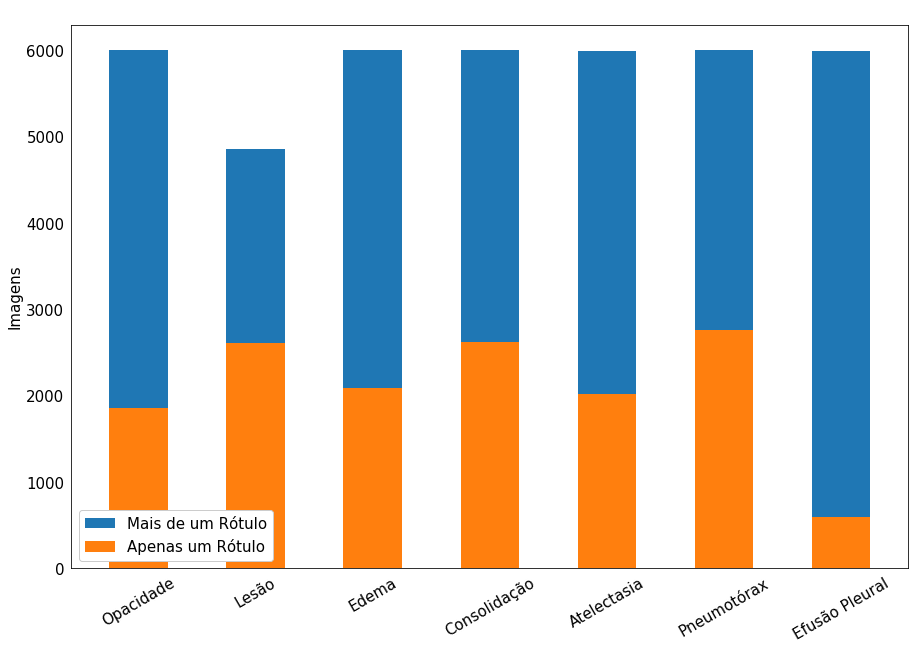

In [23]:
labels_tot = np.concatenate([train_gen.labels, valid_gen.labels, test_Y])

plt.figure(figsize=(15, 10))
plt.xticks(rotation = 30, size = 15)
plt.bar(x = labels_editada, height = np.sum(labels_tot, axis = 0), width = 0.5, label = 'Mais de um Rótulo')
plt.yticks(size = 15)
plt.legend(fontsize = 15, loc = 3, framealpha = 1)

data_analisys = pd.DataFrame(labels_tot)

individual_opacity = data_analisys[(data_analisys[0] == 1.) & (data_analisys[1] != 1.) & (data_analisys[2] != 1.) &
                                   (data_analisys[3] != 1.) & (data_analisys[4] != 1.) & (data_analisys[5] != 1.) &
                                   (data_analisys[6] != 1.)]

individual_lesion = data_analisys[(data_analisys[0] != 1.) & (data_analisys[1] == 1.) & (data_analisys[2] != 1.) &
                                  (data_analisys[3] != 1.) & (data_analisys[4] != 1.) & (data_analisys[5] != 1.) &
                                  (data_analisys[6] != 1.)]

individual_edema = data_analisys[(data_analisys[0] != 1.) & (data_analisys[1] != 1.) & (data_analisys[2] == 1.) &
                                 (data_analisys[3] != 1.) & (data_analisys[4] != 1.) & (data_analisys[5] != 1.) &
                                 (data_analisys[6] != 1.)]

individual_consolidation = data_analisys[(data_analisys[0] != 1.) & (data_analisys[1] != 1.) & (data_analisys[2] != 1.) &
                                         (data_analisys[3] == 1.) & (data_analisys[4] != 1.) & (data_analisys[5] != 1.) &
                                         (data_analisys[6] != 1.)]

individual_atelectasis = data_analisys[(data_analisys[0] != 1.) & (data_analisys[1] != 1.) & (data_analisys[2] != 1.) &
                                       (data_analisys[3] != 1.) & (data_analisys[4] == 1.) & (data_analisys[5] != 1.) &
                                       (data_analisys[6] != 1.)]

individual_pneumothorax = data_analisys[(data_analisys[0] != 1.) & (data_analisys[1] != 1.) & (data_analisys[2] != 1.) &
                                        (data_analisys[3] != 1.) & (data_analisys[4] != 1.) & (data_analisys[5] == 1.) &
                                        (data_analisys[6] != 1.)]

individual_effusion = data_analisys[(data_analisys[0] != 1.) & (data_analisys[1] != 1.) & (data_analisys[2] != 1.) &
                                    (data_analisys[3] != 1.) & (data_analisys[4] != 1.) & (data_analisys[5] != 1.) &
                                    (data_analisys[6] == 1.)]

individual = np.array([len(individual_opacity), len(individual_lesion), len(individual_edema), len(individual_consolidation),
                       len(individual_atelectasis), len(individual_pneumothorax), len(individual_effusion)])

plt.rcParams.update({'text.color': "black", 'axes.labelcolor': "black"})
plt.bar(x=labels_editada, height=individual, width=0.5, label = 'Apenas um Rótulo')
plt.legend(fontsize=15, loc=3, framealpha=1)
plt.title('Distribuição das Imagens Selecionadas do CheXpert', size=15, )
plt.xticks(color = 'black')
plt.yticks(color = 'black')
plt.ylabel('Imagens', size=15, color = 'black')

(array([  0., 100., 200., 300., 400., 500., 600., 700.]),
 <a list of 8 Text yticklabel objects>)

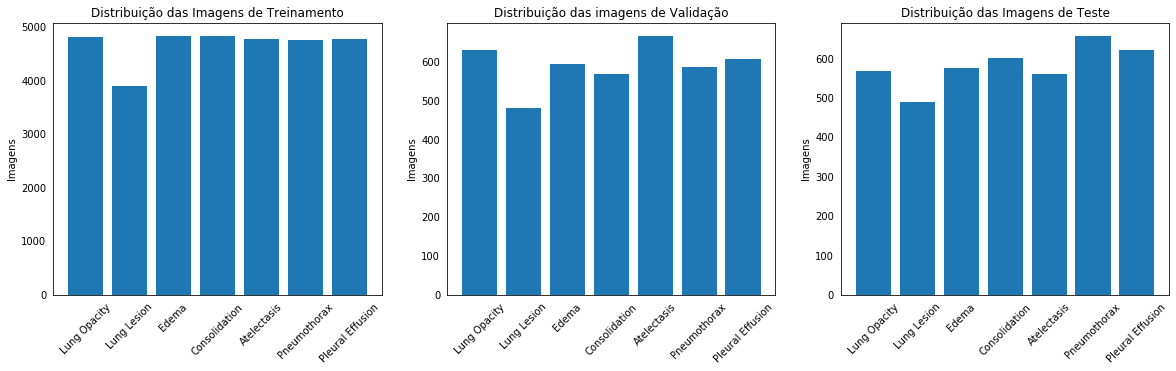

In [24]:
plt.figure(figsize = (20, 5))

plt.subplot(1, 3, 1)
plt.xticks(rotation=45)
plt.bar(x=labels, height=np.sum(train_gen.labels, axis=0))
plt.title("Distribuição das Imagens de Treinamento")
plt.ylabel('Imagens')
plt.xticks(color = 'black')
plt.yticks(color = 'black')

plt.subplot(1, 3, 2)
plt.xticks(rotation=45)
plt.bar(x=labels, height=np.sum(valid_gen.labels, axis=0))
plt.title("Distribuição das imagens de Validação")
plt.ylabel('Imagens')
plt.xticks(color = 'black')
plt.yticks(color = 'black')

plt.subplot(1, 3, 3)
plt.xticks(rotation=45)
plt.bar(x=labels, height=np.sum(test_Y, axis=0))
plt.title("Distribuição das Imagens de Teste")
plt.ylabel('Imagens')
plt.xticks(color = 'black')
plt.yticks(color = 'black')

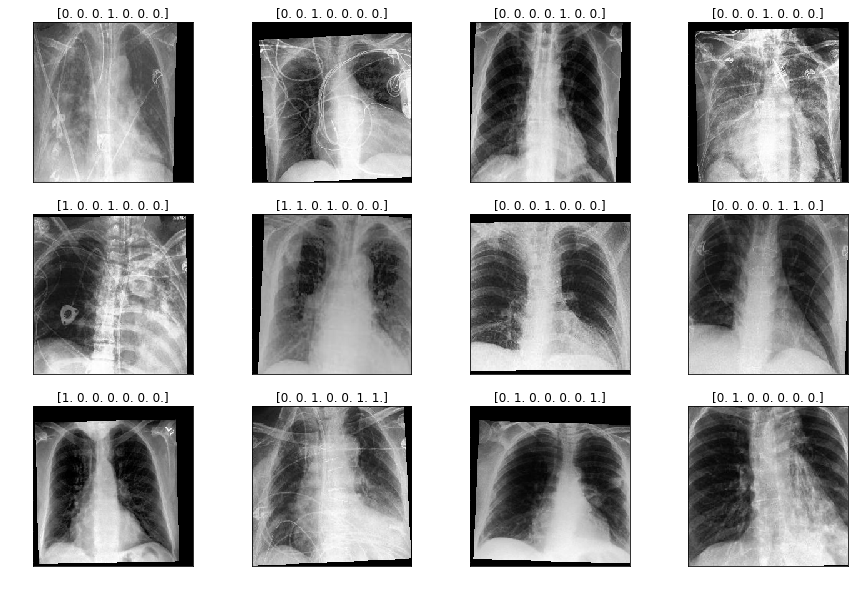

In [25]:
(x, y) = train_gen[random.randrange(0, len(train_gen))]
fig, axs = plt.subplots(nrows = 3, ncols = 4, figsize = (15, 10))
count = 0
for i in range(0, 3):
  for j in range(0, 4):
    axs[i, j].set_title(str(y[count]))
    axs[i, j].imshow(x[count])
    count +=1

In [33]:
def get_callbacks(model_name, monitor = 'val_auc'):
  '''
  define os callbacks do modelo

  Args:
    model name (str) --> nome do modelo em análise
    monitor (str) --> métrica de monitoramento do modelo

  Returns:
    callbacks (list) --> lista de callbacks úteis para o modelo
  '''

  checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = f'model.{model_name}.h5',
                                                  verbose = 1, save_best_only = True, 
                                                  monitor = monitor, mode = 'max')
   
  reducelr = tf.keras.callbacks.ReduceLROnPlateau(monitor = monitor, factor = 0.6, min_delta = 1e-5, 
                                                  patience = 2, verbose = 1, mode = 'max')
  
  callbacks = [checkpoint, reducelr]
  
  return callbacks

In [26]:
labels_portugues = ['Opacidade Pulmonar', 'Lesão Pulmonoar', 'Edema', 'Consolidação', 
                    'Atelectasia', 'Pneumotórax', 'Efusão Pleural']

### Model 1 - DenseNet121
***

In [ ]:
base_model = DenseNet121(include_top = False, weights = 'imagenet', input_shape = (256, 256, 3))
base_out = base_model.output
global_average = tf.keras.layers.GlobalAveragePooling2D()(base_out)
dropout = tf.keras.layers.Dropout(rate = 0.2)(global_average)
output = tf.keras.layers.Dense(len(labels), activation = 'sigmoid')(dropout)

model_densenet = tf.keras.Model(inputs = base_model.input, outputs = output)

model_densenet.compile(optimizer = 'adam', loss = 'binary_crossentropy', 
                       metrics=[tf.keras.metrics.AUC(multi_label = True)])

callbacks = get_callbacks('densenet121', 'val_auc_4')

model_densenet.fit(train_gen, steps_per_epoch = len(train_df) / batch_size,
                   validation_data= valid_gen, epochs = 25, callbacks = callbacks)

Epoch 1/25
629/629 [==============================] - 277s 423ms/step - loss: 0.5135 - auc_4: 0.6577 - val_loss: 0.5550 - val_auc_4: 0.6813

Epoch 00001: val_auc_4 improved from -inf to 0.68133, saving model to model.inceptionv3.h5
Epoch 2/25
629/629 [==============================] - 260s 413ms/step - loss: 0.4911 - auc_4: 0.6998 - val_loss: 0.5387 - val_auc_4: 0.6909

Epoch 00002: val_auc_4 improved from 0.68133 to 0.69091, saving model to model.inceptionv3.h5
Epoch 3/25
629/629 [==============================] - 260s 413ms/step - loss: 0.4825 - auc_4: 0.7144 - val_loss: 0.5926 - val_auc_4: 0.7006

Epoch 00003: val_auc_4 improved from 0.69091 to 0.70057, saving model to model.inceptionv3.h5
Epoch 4/25
629/629 [==============================] - 260s 413ms/step - loss: 0.4734 - auc_4: 0.7285 - val_loss: 0.5505 - val_auc_4: 0.6947

Epoch 00004: val_auc_4 did not improve from 0.70057
Epoch 5/25
629/629 [==============================] - 260s 412ms/step - loss: 0.4678 - auc_4: 0.7369 - va

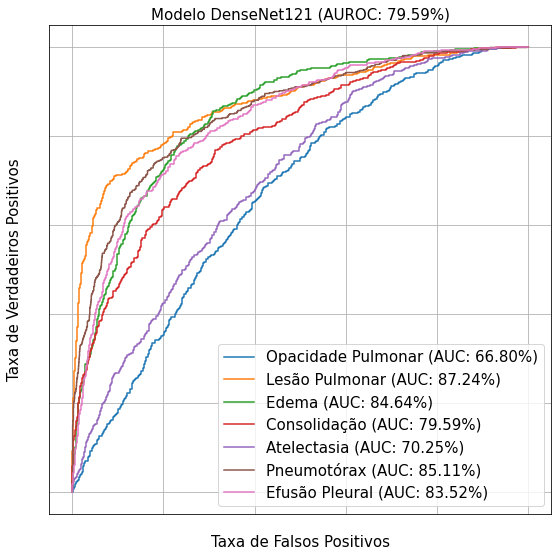

In [ ]:
model_densenet.load_weights('/content/model.densenet121.h5')
y_pred = model_densenet.predict(test_X)

fig, c_ax = plt.subplots(nrows = 1, ncols = 1, figsize=(9, 9))
for (idx, c_label) in enumerate(labels_portugues):
    fpr, tpr, thresholds = roc_curve(test_Y[:, idx].astype(int), y_pred[:, idx])
    c_ax.plot(fpr, tpr, label='{} (AUC: {:.2f}%)'.format(c_label, auc(fpr, tpr) * 100))
c_ax.legend(fontsize=15)
c_ax.set_xlabel('Taxa de Falsos Positivos', size = 15)
c_ax.set_ylabel('Taxa de Verdadeiros Positivos', size = 15)
c_ax.set_title('Modelo DenseNet121 (AUROC: ' + str(roc_auc_score(test_Y.astype(int), y_pred) * 100)[0:5] + '%)', size = 15)
c_ax.grid(True)

In [ ]:
print('Mean Square Error: {:.2f}%'.format(mean_squared_error(test_Y, y_pred) * 100))
print('Average Absolute Error: {:.2f}%'.format(mean_absolute_error(test_Y, y_pred) * 100))
print('AUROC: {:.2f}%'.format(roc_auc_score(test_Y.astype(int), y_pred) * 100))

Erro Quadrático Médio: 15.57%
Erro Absoluto Médio: 21.91%
AUROC: 79.59%


In [ ]:
model_densenet.save('densenet121_model')

### Model 2 - InceptionV3
***

In [ ]:
base_model = InceptionV3(include_top = False, weights = 'imagenet', input_shape = (256, 256, 3))
base_out = base_model.output
global_average = tf.keras.layers.GlobalAveragePooling2D()(base_out)
dropout = tf.keras.layers.Dropout(rate = 0.2)(global_average)
output = tf.keras.layers.Dense(len(labels), activation = 'sigmoid')(dropout)

model_inception = tf.keras.Model(inputs = base_model.input, outputs = output)

model_inception.compile(optimizer = 'adam', loss = 'binary_crossentropy', 
                        metrics=[tf.keras.metrics.AUC(multi_label = True)])

callbacks = get_callbacks('inceptionv3', 'val_auc_5')

model_inception.fit(train_gen, steps_per_epoch = len(train_df) / batch_size,
                    validation_data= valid_gen, epochs = 25, callbacks = callbacks)

87924736/87910968 [==============================] - 0s 0us/step
Epoch 1/25
629/629 [==============================] - 272s 418ms/step - loss: 0.5093 - auc_5: 0.6578 - val_loss: 0.5680 - val_auc_5: 0.6906

Epoch 00001: val_auc_5 improved from -inf to 0.69061, saving model to model.inceptionv3.h5
Epoch 2/25
629/629 [==============================] - 254s 404ms/step - loss: 0.4849 - auc_5: 0.7079 - val_loss: 0.5517 - val_auc_5: 0.7085

Epoch 00002: val_auc_5 improved from 0.69061 to 0.70852, saving model to model.inceptionv3.h5
Epoch 3/25
629/629 [==============================] - 255s 406ms/step - loss: 0.4743 - auc_5: 0.7255 - val_loss: 0.4953 - val_auc_5: 0.7185

Epoch 00003: val_auc_5 improved from 0.70852 to 0.71849, saving model to model.inceptionv3.h5
Epoch 4/25
629/629 [==============================] - 256s 407ms/step - loss: 0.4661 - auc_5: 0.7388 - val_loss: 0.5390 - val_auc_5: 0.7150

Epoch 00004: val_auc_5 did not improve from 0.71849
Epoch 5/25
629/629 [====================

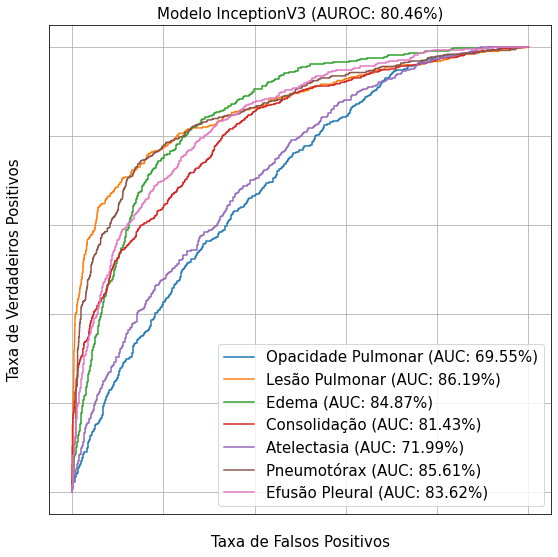

In [ ]:
model_inception.load_weights('/content/model.inceptionv3.h5')
y_pred = model_inception.predict(test_X)

fig, c_ax = plt.subplots(nrows = 1, ncols = 1, figsize=(9, 9))
for (idx, c_label) in enumerate(labels_portugues):
    fpr, tpr, thresholds = roc_curve(test_Y[:, idx].astype(int), y_pred[:, idx])
    c_ax.plot(fpr, tpr, label='{} (AUC: {:.2f}%)'.format(c_label, auc(fpr, tpr) * 100))
c_ax.legend(fontsize=15)
c_ax.set_xlabel('Taxa de Falsos Positivos', size = 15)
c_ax.set_ylabel('Taxa de Verdadeiros Positivos', size = 15)
c_ax.set_title('Modelo InceptionV3 (AUROC: ' + str(roc_auc_score(test_Y.astype(int), y_pred) * 100)[0:5] + '%)', size = 15)
c_ax.grid(True)

In [ ]:
print('Mean Square Error: {:.2f}%'.format(mean_squared_error(test_Y, y_pred) * 100))
print('Average Absolute Error: {:.2f}%'.format(mean_absolute_error(test_Y, y_pred) * 100))
print('AUROC: {:.2f}%'.format(roc_auc_score(test_Y.astype(int), y_pred) * 100))

Erro Quadrático Médio: 14.75%
Erro Absoluto Médio: 21.98%
AUROC: 80.47%


In [ ]:
model_inception.save('inceptionv3_model')

### Model 3 - Xception
***

In [ ]:
base_model = Xception(include_top = False, weights = 'imagenet', input_shape = (256, 256, 3))
base_out = base_model.output
global_average = tf.keras.layers.GlobalAveragePooling2D()(base_out)
dropout = tf.keras.layers.Dropout(rate = 0.2)(global_average)
output = tf.keras.layers.Dense(len(labels), activation = 'sigmoid')(dropout)

model_xception = tf.keras.Model(inputs = base_model.input, outputs = output)

model_xception.compile(optimizer = 'adam', loss = 'binary_crossentropy', 
                        metrics=[tf.keras.metrics.AUC(multi_label = True)])

callbacks = get_callbacks('xception', 'val_auc_6')

model_xception.fit(train_gen, steps_per_epoch = len(train_df) / batch_size,
                   validation_data= valid_gen, epochs = 25, callbacks = callbacks)

83697664/83683744 [==============================] - 1s 0us/step
Epoch 1/25
629/629 [==============================] - 332s 518ms/step - loss: 0.4881 - auc_6: 0.7025 - val_loss: 0.5840 - val_auc_6: 0.7176

Epoch 00001: val_auc_6 improved from -inf to 0.71760, saving model to model.xception.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
629/629 [==============================] - 327s 519ms/step - loss: 0.4627 - auc_6: 0.7444 - val_loss: 0.5336 - val_auc_6: 0.7349

Epoch 00002: val_auc_6 improved from 0.71760 to 0.73491, saving model to model.xception.h5
Epoch 3/25
629/629 [==============================] - 325s 516ms/step - loss: 0.4481 - auc_6: 0.7652 - val_loss: 0.4759 - val_auc_6: 0.7545

Epoch 00003: val_auc_6 improved from 0.73491 to 0.75447, saving model to model.xception.h5
Epoch 4/25
629/629 [==============================] - 325s 516ms/step - loss: 0.4349 - auc_6: 0.7824 - val_loss: 0.4950 - val_auc_6: 0.7613

Epoch 00004: val_auc_6 improved from 0.75447 to 0.76131, saving model to model.xception.h5
Epoch 5/25
629/629 [==============================] - 325s 516ms/step - loss: 0.4204 - auc_6: 0.7991 - val_loss: 0.5739 - val_auc_6: 0.7319

Epoch 00005: val_auc_6 did not improve from 0.76131
Epoch 6/25
629/629 [==============================] - 325s 516ms/step - loss: 0.4044 - auc_6: 0.8158 - val_loss

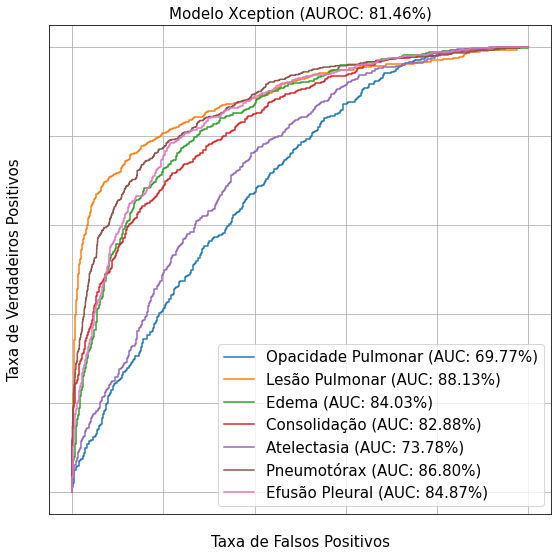

In [ ]:
model_xception.load_weights('/content/model.xception.h5')
y_pred = model_xception.predict(test_X)

fig, c_ax = plt.subplots(1, 1, figsize=(9, 9))
for (idx, c_label) in enumerate(labels_portugues):
    fpr, tpr, thresholds = roc_curve(test_Y[:, idx].astype(int), y_pred[:, idx])
    c_ax.plot(fpr, tpr, label='{} (AUC: {:.2f}%)'.format(c_label, auc(fpr, tpr) * 100))
c_ax.legend(fontsize=15)
c_ax.set_xlabel('Taxa de Falsos Positivos', size = 15)
c_ax.set_ylabel('Taxa de Verdadeiros Positivos', size = 15)
c_ax.set_title('Modelo Xception (AUROC: ' + str(roc_auc_score(test_Y.astype(int), y_pred) * 100)[0:5] + '%)', size = 15)
c_ax.grid(True)

In [ ]:
print('Mean Square Error: {:.2f}%'.format(mean_squared_error(test_Y, y_pred) * 100))
print('Average Absolute Error: {:.2f}%'.format(mean_absolute_error(test_Y, y_pred) * 100))
print('AUROC: {:.2f}%'.format(roc_auc_score(test_Y.astype(int), y_pred) * 100))

Erro Quadrático Médio: 15.64%
Erro Absoluto Médio: 21.30%
AUROC: 81.47%


In [ ]:
model_xception.save('xception_model')

### Model 4 - InceptionResNetV2
***

In [ ]:
base_model = InceptionResNetV2(include_top = False, weights = 'imagenet', input_shape = (256, 256, 3))
base_out = base_model.output
global_average = tf.keras.layers.GlobalAveragePooling2D()(base_out)
dropout = tf.keras.layers.Dropout(rate = 0.2)(global_average)
output = tf.keras.layers.Dense(len(labels), activation = 'sigmoid')(dropout)

model_inceptionresnet = tf.keras.Model(inputs = base_model.input, outputs = output)

model_inceptionresnet.compile(optimizer = 'adam', loss = 'binary_crossentropy', 
                               metrics=[tf.keras.metrics.AUC(multi_label = True)])

callbacks = get_callbacks('inceptionresnetv2', 'val_auc_7')

model_inceptionresnet.fit(train_gen, steps_per_epoch = len(train_df) / batch_size,
                          validation_data= valid_gen, epochs = 25, callbacks = callbacks)

219070464/219055592 [==============================] - 1s 0us/step
Epoch 1/25
629/629 [==============================] - 301s 450ms/step - loss: 0.4927 - auc_7: 0.6962 - val_loss: 0.5036 - val_auc_7: 0.7261

Epoch 00001: val_auc_7 improved from -inf to 0.72606, saving model to model.inceptionresnetv2.h5
Epoch 2/25
629/629 [==============================] - 273s 433ms/step - loss: 0.4665 - auc_7: 0.7397 - val_loss: 0.5276 - val_auc_7: 0.7410

Epoch 00002: val_auc_7 improved from 0.72606 to 0.74096, saving model to model.inceptionresnetv2.h5
Epoch 3/25
629/629 [==============================] - 272s 433ms/step - loss: 0.4558 - auc_7: 0.7557 - val_loss: 0.5452 - val_auc_7: 0.7472

Epoch 00003: val_auc_7 improved from 0.74096 to 0.74716, saving model to model.inceptionresnetv2.h5
Epoch 4/25
629/629 [==============================] - 273s 433ms/step - loss: 0.4439 - auc_7: 0.7713 - val_loss: 0.5446 - val_auc_7: 0.7359

Epoch 00004: val_auc_7 did not improve from 0.74716
Epoch 5/25
629/629 [

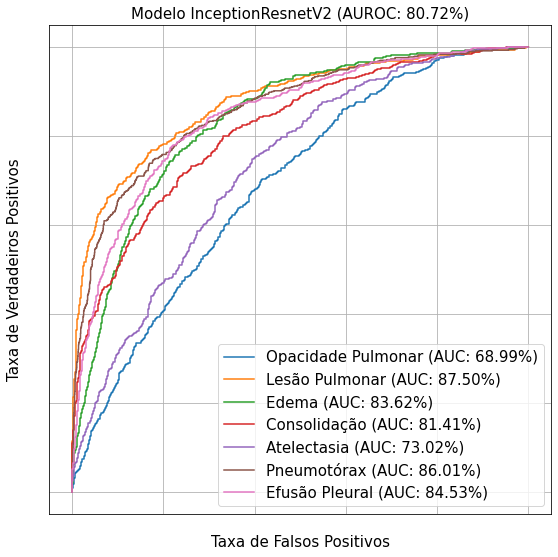

In [ ]:
model_inceptionresnet.load_weights('/content/model.inceptionresnetv2.h5')
y_pred = model_inceptionresnet.predict(test_X)

fig, c_ax = plt.subplots(1, 1, figsize=(9, 9))
for (idx, c_label) in enumerate(labels_portugues):
    fpr, tpr, thresholds = roc_curve(test_Y[:, idx].astype(int), y_pred[:, idx])
    c_ax.plot(fpr, tpr, label='{} (AUC: {:.2f}%)'.format(c_label, auc(fpr, tpr) * 100))
c_ax.legend(fontsize=15)
c_ax.set_xlabel('Taxa de Falsos Positivos', size = 15)
c_ax.set_ylabel('Taxa de Verdadeiros Positivos', size = 15)
c_ax.set_title('Modelo InceptionResnetV2 (AUROC: ' + str(roc_auc_score(test_Y.astype(int), y_pred) * 100)[0:5] + '%)', size = 15)
c_ax.grid(True)

In [ ]:
print('Mean Square Error: {:.2f}%'.format(mean_squared_error(test_Y, y_pred) * 100))
print('Average Absolute Error: {:.2f}%'.format(mean_absolute_error(test_Y, y_pred) * 100))
print('AUROC: {:.2f}%'.format(roc_auc_score(test_Y.astype(int), y_pred) * 100))

Erro Quadrático Médio: 14.91%
Erro Absoluto Médio: 22.36%
AUROC: 80.73%


In [ ]:
model_inceptionresnet.save('inceptionresnetv2_model')

### Model 5 - ResNet101V2
***

In [ ]:
base_model = ResNet101V2(include_top = False, weights = 'imagenet', input_shape = (256, 256, 3))
base_out = base_model.output
global_average = tf.keras.layers.GlobalAveragePooling2D()(base_out)
dropout = tf.keras.layers.Dropout(rate = 0.2)(global_average)
output = tf.keras.layers.Dense(len(labels), activation = 'sigmoid')(dropout)

model_resnet = tf.keras.Model(inputs = base_model.input, outputs = output)

model_resnet.compile(optimizer = 'adam', loss = 'binary_crossentropy', 
                     metrics=[tf.keras.metrics.AUC(multi_label = True)])

callbacks = get_callbacks('resnet101v2', 'val_auc_9')

model_resnet.fit(train_gen, steps_per_epoch = len(train_df) / batch_size,
                 validation_data= valid_gen, epochs = 25, callbacks = callbacks)

171327488/171317808 [==============================] - 1s 0us/step
Epoch 1/25
629/629 [==============================] - 280s 427ms/step - loss: 0.5160 - auc_9: 0.6437 - val_loss: 0.5544 - val_auc_9: 0.6666

Epoch 00001: val_auc_9 improved from -inf to 0.66660, saving model to model.resnet101v2.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
629/629 [==============================] - 267s 425ms/step - loss: 0.4991 - auc_9: 0.6801 - val_loss: 0.5209 - val_auc_9: 0.6817

Epoch 00002: val_auc_9 improved from 0.66660 to 0.68166, saving model to model.resnet101v2.h5
Epoch 3/25
629/629 [==============================] - 266s 422ms/step - loss: 0.4898 - auc_9: 0.6991 - val_loss: 0.6288 - val_auc_9: 0.6433

Epoch 00003: val_auc_9 did not improve from 0.68166
Epoch 4/25
629/629 [==============================] - 268s 425ms/step - loss: 0.4840 - auc_9: 0.7098 - val_loss: 0.5803 - val_auc_9: 0.6868

Epoch 00004: val_auc_9 improved from 0.68166 to 0.68679, saving model to model.resnet101v2.h5
Epoch 5/25
629/629 [==============================] - 266s 422ms/step - loss: 0.4782 - auc_9: 0.7190 - val_loss: 0.5494 - val_auc_9: 0.6658

Epoch 00005: val_auc_9 did not improve from 0.68679
Epoch 6/25
629/629 [==============================] - 267s 423ms/step - loss: 0.4749 - auc_9: 0.7244 - val_loss: 0.7127 - val_auc_9: 0.6523

Epo

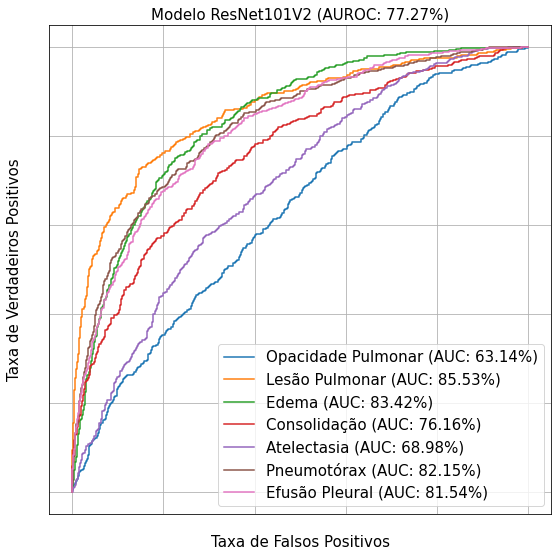

In [ ]:
model_resnet.load_weights('/content/model.resnet101v2.h5')
y_pred = model_resnet.predict(test_X)

fig, c_ax = plt.subplots(1, 1, figsize=(9, 9))
for (idx, c_label) in enumerate(labels_portugues):
    fpr, tpr, thresholds = roc_curve(test_Y[:, idx].astype(int), y_pred[:, idx])
    c_ax.plot(fpr, tpr, label='{} (AUC: {:.2f}%)'.format(c_label, auc(fpr, tpr) * 100))
c_ax.legend(fontsize=15)
c_ax.set_xlabel('Taxa de Falsos Positivos', size = 15)
c_ax.set_ylabel('Taxa de Verdadeiros Positivos', size = 15)
c_ax.set_title('Modelo ResNet101V2 (AUROC: ' + str(roc_auc_score(test_Y.astype(int), y_pred)*100)[0:5] + '%)', size = 15)
c_ax.grid(True)

In [ ]:
print('Erro Quadrático Médio: {:.2f}%'.format(mean_squared_error(test_Y, y_pred)*100))
print('Erro Absoluto Médio: {:.2f}%'.format(mean_absolute_error(test_Y, y_pred)*100))
print('AUROC: {:.2f}%'.format(roc_auc_score(test_Y.astype(int), y_pred)*100))

Mean Square Error: 15.42%
Average Absolute Error: 24.58%
AUROC: 77.27%


In [ ]:
model_resnet.save('resnet101v2_model')

INFO:tensorflow:Assets written to: resnet101v2_model/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


### Modelo 7 - MobileNetV2
***

In [35]:
base_model = MobileNetV2(include_top = False, weights = 'imagenet', input_shape = (256, 256, 3))
base_out = base_model.output
global_average = tf.keras.layers.GlobalAveragePooling2D()(base_out)
dropout = tf.keras.layers.Dropout(rate = 0.2)(global_average)
output = tf.keras.layers.Dense(len(labels), activation = 'sigmoid')(dropout)

model_mobilenet = tf.keras.Model(inputs = base_model.input, outputs = output)

model_mobilenet.compile(optimizer = 'adam', loss = 'binary_crossentropy', 
                        metrics=[tf.keras.metrics.AUC(multi_label = True)])

callbacks = get_callbacks('mobilenetv2', 'val_auc_1')

model_mobilenet.fit(train_gen, steps_per_epoch = len(train_df) / batch_size,
                    validation_data= valid_gen, epochs = 25, callbacks = callbacks)

Epoch 1/25
629/629 [==============================] - 254s 397ms/step - loss: 0.4952 - auc_1: 0.6925 - val_loss: 1.2641 - val_auc_1: 0.5825

Epoch 00001: val_auc_1 improved from -inf to 0.58251, saving model to model.mobilenetv2.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
629/629 [==============================] - 248s 394ms/step - loss: 0.4702 - auc_1: 0.7345 - val_loss: 0.9759 - val_auc_1: 0.6314

Epoch 00002: val_auc_1 improved from 0.58251 to 0.63143, saving model to model.mobilenetv2.h5
Epoch 3/25
629/629 [==============================] - 248s 394ms/step - loss: 0.4611 - auc_1: 0.7480 - val_loss: 0.6617 - val_auc_1: 0.6993

Epoch 00003: val_auc_1 improved from 0.63143 to 0.69933, saving model to model.mobilenetv2.h5
Epoch 4/25
629/629 [==============================] - 249s 395ms/step - loss: 0.4531 - auc_1: 0.7595 - val_loss: 0.8040 - val_auc_1: 0.6703

Epoch 00004: val_auc_1 did not improve from 0.69933
Epoch 5/25
629/629 [==============================] - 249s 395ms/step - loss: 0.4472 - auc_1: 0.7675 - val_loss: 0.9400 - val_auc_1: 0.6507

Epoch 00005: val_auc_1 did not improve from 0.69933

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.
Epoch 6/25
629/629 [==============================] - 248s 394m

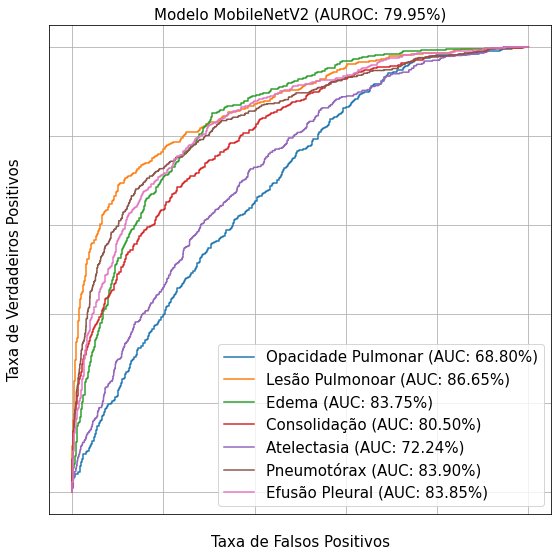

In [39]:
model_mobilenet.load_weights('/content/model.mobilenetv2.h5')
y_pred = model_mobilenet.predict(test_X)

fig, c_ax = plt.subplots(1, 1, figsize=(9, 9))
for (idx, c_label) in enumerate(labels_portugues):
    fpr, tpr, thresholds = roc_curve(test_Y[:, idx].astype(int), y_pred[:, idx])
    c_ax.plot(fpr, tpr, label='{} (AUC: {:.2f}%)'.format(c_label, auc(fpr, tpr) * 100))
c_ax.legend(fontsize=15)
c_ax.set_xlabel('Taxa de Falsos Positivos', size=15)
c_ax.set_ylabel('Taxa de Verdadeiros Positivos', size=15)
c_ax.set_title('Modelo MobileNetV2 (AUROC: ' + str(roc_auc_score(test_Y.astype(int), y_pred)*100)[0:5] + '%)', size=15)
c_ax.grid(True)

In [40]:
print('Erro Quadrático Médio: {:.2f}%'.format(mean_squared_error(test_Y, y_pred)*100))
print('Erro Absoluto Médio: {:.2f}%'.format(mean_absolute_error(test_Y, y_pred)*100))
print('AUROC: {:.2f}%'.format(roc_auc_score(test_Y.astype(int), y_pred)*100))

Erro Quadrático Médio: 14.78%
Erro Absoluto Médio: 22.13%
AUROC: 79.96%


In [ ]:
model_mobilenet.save('mobilenetv2_model')

### Saving Trained models
***

In [ ]:
!zip -r /content/densenet121_model.zip /content/densenet121_model
!zip -r /content/inceptionv3_model.zip /content/inceptionv3_model
!zip -r /content/xception_model.zip /content/xception_model
!zip -r /content/inceptionresnetv2_model.zip /content/inceptionresnetv2_model
!zip -r /content/resnet101v2_model.zip /content/resnet101v2_model
!zip -r /content/mobilenetv2_model.zip /content/mobilenetv2_model

In [43]:
!cp -r /content/densenet121_model.zip /content/gdrive/MyDrive/lung-localization/classification-tests/
!cp -r /content/inceptionv3_model.zip /content/gdrive/MyDrive/lung-localization/classification-tests/
!cp -r /content/xception_model.zip /content/gdrive/MyDrive/lung-localization/classification-tests/
!cp -r /content/inceptionresnetv2_model.zip /content/gdrive/MyDrive/lung-localization/classification-tests/
!cp -r /content/resnet101v2_model.zip /content/gdrive/MyDrive/lung-localization/classification-tests/
!cp -r /content/mobilenetv2_model.zip /content/gdrive/MyDrive/lung-localization/classification-tests/

### Média Ponderada - Estratégia de Comitê
***

In [45]:
def weighted_average(true_label, *predictions):
  '''
  pondera as predições do modelo com os seus respectivos valores de AUROC

  Args:
    true_label (array) --> rotulações originais dos dados de teste
    predictions (*args) --> predições dos modelos 
  
  Returns:
    average_predictions (array) --> média ponderada da predição dos modelos
  '''

  average_predictions = np.zeros(true_label.shape)
  for count, prediction in enumerate(predictions):
    average_predictions += np.array(prediction) * roc_auc_score(true_label.astype(int),  np.array(prediction))

  return average_predictions / (count + 1)

In [42]:
y_pred1 = model_densenet.predict(test_X)
y_pred2 = model_inception.predict(test_X)
y_pred3 = model_xception.predict(test_X)
y_pred4 = model_inceptionresnet.predict(test_X)
y_pred5 = model_resnet.predict(test_X)
y_pred6 = model_mobilenet.predict(test_X)

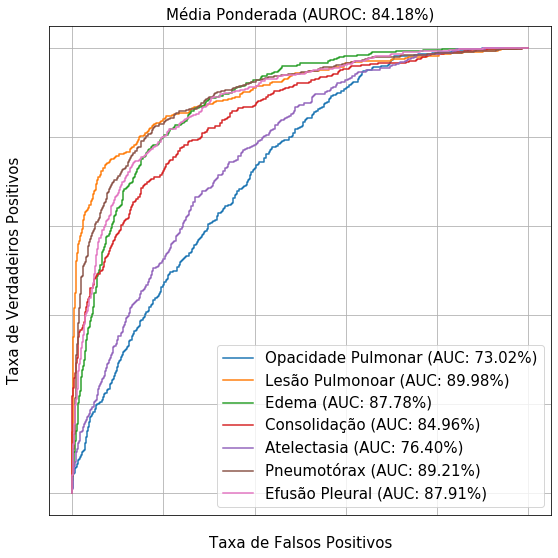

In [46]:
y_pred = weighted_average(test_Y, y_pred1, y_pred2, y_pred3, y_pred4, y_pred5, y_pred6)

fig, c_ax = plt.subplots(1, 1, figsize=(9, 9))
for (idx, c_label) in enumerate(labels_portugues):
    fpr, tpr, thresholds = roc_curve(test_Y[:, idx].astype(int), y_pred[:, idx])
    c_ax.plot(fpr, tpr, label='{} (AUC: {:.2f}%)'.format(c_label, auc(fpr, tpr) * 100))
c_ax.legend(fontsize=15)
c_ax.set_xlabel('Taxa de Falsos Positivos', size=15)
c_ax.set_ylabel('Taxa de Verdadeiros Positivos', size=15)
c_ax.set_title('Média Ponderada (AUROC: ' + str(roc_auc_score(test_Y.astype(int), y_pred)*100)[0:5] + '%)', size=15)
c_ax.grid(True)

In [44]:
print('Erro Quadrático Médio: {:.2f}%'.format(mean_squared_error(test_Y, y_pred)*100))
print('Erro Absoluto Médio: {:.2f}%'.format(mean_absolute_error(test_Y, y_pred)*100))
print('AUROC: {:.2f}%'.format(roc_auc_score(test_Y.astype(int), y_pred)*100))

Erro Quadrático Médio: 11.90%
Erro Absoluto Médio: 22.39%
AUROC: 84.18%


### Média Simples - Estratégia de Comitê
***

In [48]:
def average(*predictions):
  '''
  pondera as predições do modelo com os seus respectivos valores de AUROC

  Args:
    true_label (array) --> rotulações originais dos dados de teste
    predictions (*args) --> predições dos modelos 
  
  Returns:
    average_predictions (array) --> média ponderada da predição dos modelos
  '''

  for count, prediction in enumerate(predictions):
    if count == 0:
      average_predictions = np.zeros(prediction.shape)
    average_predictions += np.array(prediction) 

  return average_predictions / (count + 1)

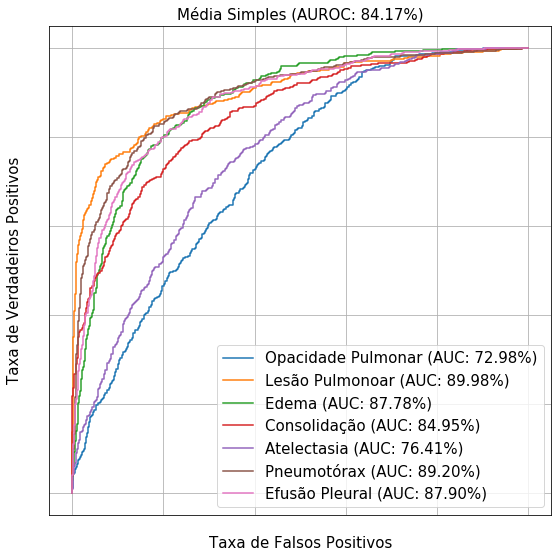

In [49]:
y_pred = average(y_pred1, y_pred2, y_pred3, y_pred4, y_pred5, y_pred6)

fig, c_ax = plt.subplots(1, 1, figsize=(9, 9))
for (idx, c_label) in enumerate(labels_portugues):
    fpr, tpr, thresholds = roc_curve(test_Y[:, idx].astype(int), y_pred[:, idx])
    c_ax.plot(fpr, tpr, label='{} (AUC: {:.2f}%)'.format(c_label, auc(fpr, tpr) * 100))
c_ax.legend(fontsize=15)
c_ax.set_xlabel('Taxa de Falsos Positivos', size=15)
c_ax.set_ylabel('Taxa de Verdadeiros Positivos', size=15)
c_ax.set_title('Média Simples (AUROC: ' + str(roc_auc_score(test_Y.astype(int), y_pred)*100)[0:5] + '%)', size=15)
c_ax.grid(True)

In [50]:
print('Erro Quadrático Médio: {:.2f}%'.format(mean_squared_error(test_Y, y_pred)*100))
print('Erro Absoluto Médio: {:.2f}%'.format(mean_absolute_error(test_Y, y_pred)*100))
print('AUROC: {:.2f}%'.format(roc_auc_score(test_Y.astype(int), y_pred)*100))

Erro Quadrático Médio: 11.90%
Erro Absoluto Médio: 22.38%
AUROC: 84.17%


### Verificando o Tempo de Inferência
***

In [52]:
images = test_X[0:50]

In [54]:
start_time = time.time()
model_densenet.predict(images)
end_time = time.time()

print('Tempo de Inferência: {} ms'.format((end_time - start_time) / 50))

Tempo de Inferência: 0.011953163146972656 ms


In [56]:
start_time = time.time()
model_inception.predict(images)
end_time = time.time()

print('Tempo de Inferência: {} ms'.format((end_time - start_time) / 50))

Tempo de Inferência: 0.003239912986755371 ms


In [59]:
start_time = time.time()
model_xception.predict(images)
end_time = time.time()

print('Tempo de Inferência: {} ms'.format((end_time - start_time) / 50))

Tempo de Inferência: 0.004371013641357422 ms


In [60]:
start_time = time.time()
model_inceptionresnet.predict(images)
end_time = time.time()

print('Tempo de Inferência: {} ms'.format((end_time - start_time) / 50))

Tempo de Inferência: 0.009045815467834473 ms


In [62]:
start_time = time.time()
model_resnet.predict(images)
end_time = time.time()

print('Tempo de Inferência: {} ms'.format((end_time - start_time) / 50))

Tempo de Inferência: 0.009593734741210938 ms


In [63]:
start_time = time.time()
model_mobilenet.predict(images)
end_time = time.time()

print('Tempo de Inferência: {} ms'.format((end_time - start_time) / 50))

Tempo de Inferência: 0.004712882041931152 ms


In [65]:
start_time = time.time()
y_pred1 = model_densenet.predict(images)
y_pred2 = model_inception.predict(images)
y_pred3 = model_xception.predict(images)
y_pred4 = model_inceptionresnet.predict(images)
y_pred5 = model_resnet.predict(images)
y_pred6 = model_mobilenet.predict(images)
y_pred = weighted_average(test_Y[0:50], y_pred1, y_pred2, y_pred3, y_pred4, y_pred5, y_pred6)
end_time = time.time()

print('Tempo de Inferência: {} ms'.format((end_time - start_time) / 50))

Tempo de Inferência: 0.025108299255371093 ms


In [66]:
start_time = time.time()
y_pred1 = model_densenet.predict(images)
y_pred2 = model_inception.predict(images)
y_pred3 = model_xception.predict(images)
y_pred4 = model_inceptionresnet.predict(images)
y_pred5 = model_resnet.predict(images)
y_pred6 = model_mobilenet.predict(images)
y_pred = average(y_pred1, y_pred2, y_pred3, y_pred4, y_pred5, y_pred6)
end_time = time.time()

print('Tempo de Inferência: {} ms'.format((end_time - start_time) / 50))

Tempo de Inferência: 0.02334463119506836 ms
